# GCN with StellarGraph

- dataset: local cora dataset

## start with node-classification

In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

### graph setting

In [2]:
# set edges
edges = pd.read_table('../datasets/cora/cora.cites', header=None)
edges.columns = ['source', 'target'] # should be follow this column name
gx = nx.from_pandas_edgelist(edges) # stellar graph form

# load features
features = pd.read_table('../datasets/cora/cora.content', header=None, index_col=0)
target = pd.DataFrame(features[features.columns[-1]].values, index=features.index)
features = features.drop(features.columns[-1], axis=1)
col_names = ['w_'+str(i) for i in range(1, 1434)]
features.columns = col_names


# make graph
G = sg.StellarGraph(gx, node_features=features)
nodes = list(G.nodes())
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  default: [2708]
    Features: float32 vector, length 1433
    Edge types: default-default->default

 Edge types:
    default-default->default: [5278]


### val-test split and OHE

In [3]:
tr_target, val_target = model_selection.train_test_split(
    target, train_size=0.2, stratify=target
)

val_target, test_target = model_selection.train_test_split(
    val_target, train_size=0.5, stratify=val_target
)

In [4]:
lbe = preprocessing.LabelBinarizer()

tr_target = pd.DataFrame(lbe.fit_transform(tr_target.values), index=tr_target.index)
val_target = pd.DataFrame(lbe.fit_transform(val_target.values), index=val_target.index)
test_target = pd.DataFrame(lbe.fit_transform(test_target.values), index=test_target.index)
tot_target = pd.DataFrame(lbe.fit_transform(target.values), index=target.index)

### node generator
- it make seperate node set with edges

In [5]:
# generator: 관련된 노드만 떼어내주는 역할을 함
from stellargraph.mapper import FullBatchNodeGenerator

generator = FullBatchNodeGenerator(G, method="gcn")


Using GCN (local pooling) filters...


In [6]:
tr_flow = generator.flow(tr_target.index, tr_target) # node_id, target
val_flow = generator.flow(val_target.index, val_target)
test_flow = generator.flow(test_target.index, test_target)
tot_flow = generator.flow(tot_target.index, tot_target)

### build implemented model

In [7]:
from stellargraph.layer import GCN
# like keras models
gcn = GCN(layer_sizes=[32, 32], activations=["elu", "elu"], generator=generator, dropout=0.5, bias=True)

In [8]:
# build network
nc_inp, nc_out = gcn.build()

In [9]:
nc_inp

[<tf.Tensor 'input_1:0' shape=(1, 2708, 1433) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(1, None) dtype=int32>,
 <tf.Tensor 'input_3:0' shape=(1, None, 2) dtype=int64>,
 <tf.Tensor 'input_4:0' shape=(1, None) dtype=float32>]

In [10]:
nc_out

<tf.Tensor 'graph_convolution_1/Identity:0' shape=(1, None, 32) dtype=float32>

### inject a few layer(FC) to better do ML things

In [11]:
nc_layer = layers.Dense(16, activation='relu')(nc_out)
nc_layer = layers.Dense(tr_target.shape[1], activation='softmax')(nc_layer)

In [12]:
nc_model = Model(inputs=nc_inp, outputs=nc_layer)
nc_model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss='categorical_crossentropy',
    metrics=["acc"],
)

In [13]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_acc')
nc_hist = nc_model.fit(tr_flow, epochs=200,
                validation_data=val_flow,
                shuffle=False, # should be False!!
                callbacks=[es],
                verbose=0)  

  ...
    to  
  ['...']
  ...
    to  
  ['...']


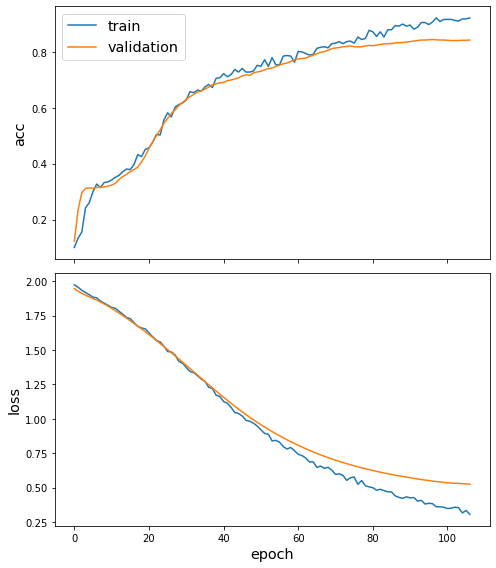

In [14]:
sg.utils.plot_history(nc_hist)

In [15]:
from sklearn.metrics import f1_score

f1_micro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (nc_model.predict(test_flow).squeeze()))), average='micro')
f1_marco = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (nc_model.predict(test_flow).squeeze()))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.844 
f1_macro: 0.836


### comparison with non-graph classification

In [16]:
from sklearn.linear_model import LogisticRegression

tr_tar = list(map(lambda x: np.argmax(x), tr_target.values))
lr = LogisticRegression().fit(features.loc[tr_target.index], tr_tar)

f1_micro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='micro')
f1_macro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.71 
f1_macro: 0.836


### visualize how it classify

In [17]:
emb_model = Model(nc_inp, nc_out)

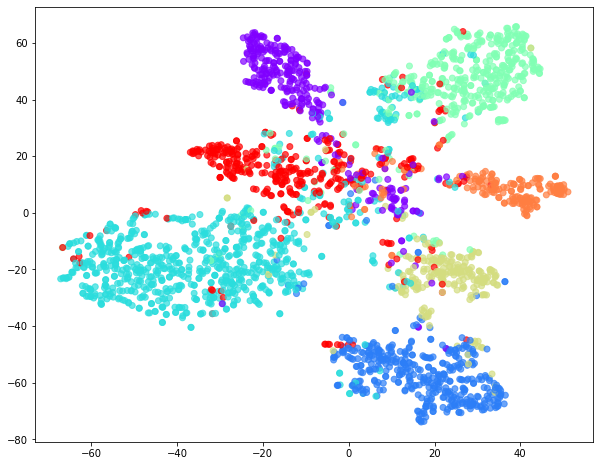

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(emb_model.predict(tot_flow).squeeze())

lbe = preprocessing.LabelEncoder()
col = lbe.fit_transform(target)

alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    cmap="rainbow",
    c=col,
    alpha=alpha,
)

## link-prediction

### use EdgeSplitter and seperate into train/val sets

In [19]:
from stellargraph.data import EdgeSplitter

G = sg.StellarGraph(gx, node_features=features)

# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)


** Sampled 527 positive and 527 negative edges. **


In [20]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)


** Sampled 475 positive and 475 negative edges. **


### Link Generator

In [21]:
from stellargraph.mapper import FullBatchLinkGenerator

train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [22]:
gcn = GCN(layer_sizes=[16, 8], activations=["relu", "relu"], generator=train_gen, dropout=0.5)

inp, out = gcn.build()

### add another layers
- especially reshape layer is needed

In [23]:
from stellargraph.layer import link_classification, LinkEmbedding

pred = link_classification()(out)

lp_model = Model(inp, pred)

lp_model.compile(
    optimizer=optimizers.Adam(lr=1e-2),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [24]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_acc')
lp_hist = lp_model.fit(train_flow , epochs=100,
                   validation_data=test_flow,
                   shuffle=False,
                   callbacks=[es],
                    verbose=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


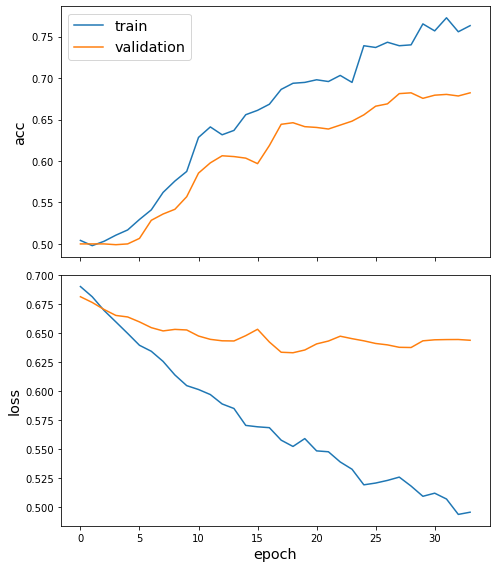

In [25]:
sg.utils.plot_history(lp_hist)

In [26]:
f1_micro = f1_score(edge_labels_test, list(map(lambda x: 1 if x>0.5 else 0, (lp_model.predict(test_flow).squeeze()))), average='micro')
f1_marco = f1_score(edge_labels_test, list(map(lambda x: 1 if x>0.5 else 0, (lp_model.predict(test_flow).squeeze()))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.682 
f1_macro: 0.671


In [27]:
nc_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 2708, 1433)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (1, 2708, 1433)      0           input_1[0][0]                    
______________________________________________________________________________________________